<a href="https://colab.research.google.com/github/selenap706/imt_542_sp/blob/main/imt542_i3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download necessary modules and commands

!pip install svgling

import io

from collections import Counter

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from urllib.parse import urlparse
import re
import requests
from google.colab import userdata
from google.colab import files

from bs4 import BeautifulSoup, SoupStrainer
from urllib.request import urlopen

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Upload goodreads dataset
goodreads_dataset = files.upload()

Saving goodreads_top100_from1980to2023_final.csv to goodreads_top100_from1980to2023_final.csv


In [3]:
# Transfer csv dataset into dataframe
file_list = list(goodreads_dataset.keys())[0]
df = pd.read_csv(io.BytesIO(goodreads_dataset[file_list]))

# Clean up publication data column to remove the "Published on" in some of the rows
df['clean_date'] = df['publication_date'].str.extract(r'(\w+ \d{1,2}, \d{4})')

# Make dataframe for genres and cleaned up date column
genre_date = df[['genres', 'clean_date']]

In [4]:
# Convert Date column to datetime format
genre_date['Date'] = pd.to_datetime(genre_date['clean_date'], format = '%B %d, %Y')

# Extract the year
genre_date['Year'] = genre_date['Date'].dt.year

# Group by genre column and Year column
grouped = genre_date.groupby(['genres', 'Year'])

# Create separate DataFrames for each year
dfs_by_year = {year: genre_date[genre_date['Year'] == year] for year in genre_date['Year'].unique()}

print(dfs_by_year[2020])

                                                 genres         clean_date  \
136   ['Fantasy', 'Fiction', 'LGBT', 'Romance', 'Que...     March 16, 2020   
137   ['LGBT', 'Contemporary', 'Queer', 'Fiction', '...       July 7, 2020   
138   ['Fiction', 'Contemporary', 'Literary Fiction'...    August 31, 2020   
139   ['Fantasy', 'LGBT', 'Young Adult', 'Queer', 'F...  September 1, 2020   
140   ['Romance', 'New Adult', 'Contemporary', 'High...   February 1, 2020   
...                                                 ...                ...   
4097  ['Memoir', 'Nonfiction', 'Biography', 'Audiobo...     April 21, 2020   
4098  ['Graphic Novels', 'Romance', 'LGBT', 'Young A...   February 6, 2020   
4099  ['Thriller', 'Mystery', 'Fiction', 'Mystery Th...      March 3, 2020   
4122  ['Fantasy', 'Young Adult', 'Fiction', 'Young A...    October 8, 2020   
4146  ['Thriller', 'Fiction', 'Mystery', 'Audiobook'...   October 27, 2020   

           Date    Year  
136  2020-03-16  2020.0  
137  2020-0

<ipython-input-4-387d63ffb8e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_date['Date'] = pd.to_datetime(genre_date['clean_date'], format = '%B %d, %Y')
<ipython-input-4-387d63ffb8e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_date['Year'] = genre_date['Date'].dt.year


In [9]:
# Join together a year's worth of book genres into one string, cleaning it up so it's just words and spaces
# Rename genre_text_2000 to match the year/years chosen to analyze
# One issue I couldn't figure out how to resolve - if a genre tag is more than one word, it gets split up and can't be linked together
# Like "Young Adult" becomes "Young" and "Adult" in the eyes of the code

genre_text_2000 = " ".join(dfs_by_year[2000]['genres'])
genre_text_2000 = genre_text_2000.replace("[", "").replace("]", "").replace("'", "").replace(",", "")
print(genre_text_2000)

Fantasy Fiction Epic Fantasy High Fantasy Science Fiction Fantasy Audiobook Epic Fantasy Young Adult Fiction Young Adult Fantasy Magic Adventure Middle Grade Historical Romance Historical Fiction Historical Fiction Audiobook Regency Adult Fiction Historical Fiction Mystery Literary Fiction Historical China Contemporary Fiction Historical Fiction Historical Novels Literary Fiction American Literature Fantasy Fiction Science Fiction Short Stories New Weird Weird Fiction Dying Earth Historical Fiction Religion Lds Lds Fiction Fiction Church Historical Lds Fiction Lds Young Adult Fantasy Religion Fiction Historical Fiction Fantasy Fiction Young Adult Childrens Animals Adventure Middle Grade Chick Lit Fiction Romance Contemporary Humor Adult Contemporary Romance Nonfiction Politics Economics Business Sociology History Society Nonfiction Writing Memoir Biography Audiobook Reference Autobiography Nonfiction History Adventure Survival Historical American History Audiobook Fiction Contemporary 

In [11]:
# Adapted from imt576_textmining.ipynb

# Tokenize words
tokens = word_tokenize(genre_text_2000)

# Part-of-speech tagging
tokens_pos = nltk.pos_tag(tokens)

# Define stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

# Filter tokens
filtered_words = [tok[0].lower() for tok in tokens_pos if tok[0].casefold() not in stop_words and len(tok[0]) > 1]

# Print results
print('Example:', tokens_pos)
print('Most frequent words:', Counter(filtered_words).most_common(15))
word_freq = dict(Counter(filtered_words).most_common())

Example: [('Fantasy', 'NNP'), ('Fiction', 'NNP'), ('Epic', 'NNP'), ('Fantasy', 'NNP'), ('High', 'NNP'), ('Fantasy', 'NNP'), ('Science', 'NNP'), ('Fiction', 'NNP'), ('Fantasy', 'NNP'), ('Audiobook', 'NNP'), ('Epic', 'NNP'), ('Fantasy', 'NNP'), ('Young', 'NNP'), ('Adult', 'NNP'), ('Fiction', 'NNP'), ('Young', 'NNP'), ('Adult', 'NNP'), ('Fantasy', 'NNP'), ('Magic', 'NNP'), ('Adventure', 'NNP'), ('Middle', 'NNP'), ('Grade', 'NNP'), ('Historical', 'NNP'), ('Romance', 'NNP'), ('Historical', 'NNP'), ('Fiction', 'NNP'), ('Historical', 'NNP'), ('Fiction', 'NNP'), ('Audiobook', 'NNP'), ('Regency', 'NNP'), ('Adult', 'NNP'), ('Fiction', 'NNP'), ('Historical', 'NNP'), ('Fiction', 'NNP'), ('Mystery', 'NNP'), ('Literary', 'NNP'), ('Fiction', 'NNP'), ('Historical', 'NNP'), ('China', 'NNP'), ('Contemporary', 'NNP'), ('Fiction', 'NNP'), ('Historical', 'NNP'), ('Fiction', 'NNP'), ('Historical', 'NNP'), ('Novels', 'NNP'), ('Literary', 'NNP'), ('Fiction', 'NNP'), ('American', 'NNP'), ('Literature', 'NNP'),

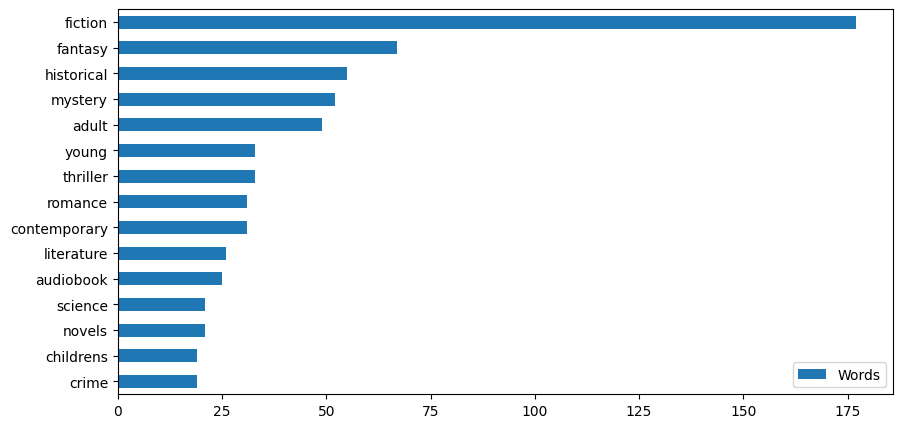

In [12]:
# Make a bar graph based on word frequency, showing the top 15 words (copied from imt576_textmining.ipynb)
df = pd.DataFrame.from_dict(dict(Counter(filtered_words).most_common(15)),orient='index',columns=['Words'])
df = df.iloc[::-1]
df.plot(kind='barh',legend=True,figsize=(10,5))
plt.show()

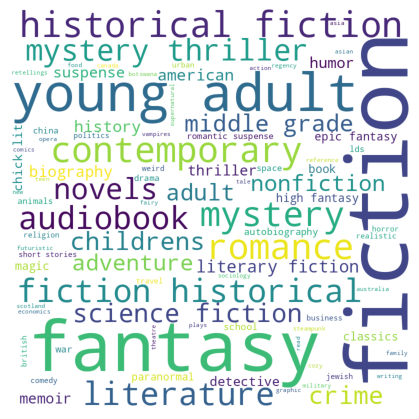

In [13]:
# Generate a word cloud (copied from imt576_textmining.ipynb)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(filtered_words))

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()